In [1]:
# %pip install -q opencv-python torch scikit-learn torchvision pillow pandas requests setuptools dlib

In [2]:
# Detect Eyes in the video stream using Haar Cascade Classifier (Inaccurate)
import cv2
import numpy as np
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

vid = cv2.VideoCapture(0)
try:
    while True:
        ret, frame = vid.read()

        image_gs = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(image_gs, 1.3, 5)
        for x, y, w, h in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            roi_gray = image_gs[y : y + h, x : x + w]
            roi_color = frame[y : y + h, x : x + w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            for ex, ey, ew, eh in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        cv2.imshow("frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
except Exception as e:
    print("Camera is Missing or not working properly :(", end="\n" * 3)
    print(e)
finally:
    vid.release()
    cv2.destroyAllWindows()

In [3]:
# Detect Individual Eyes in the video stream using Dlib (Accurate)
import dlib
import cv2
import numpy as np


class Eye:
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("../models/shape_predictor_68_face_landmarks.dat")

    def extractor_vid(frame: cv2.typing.MatLike):
        left_eyes = []
        right_eyes = []
        image_gs = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = Eye.detector(image_gs)

        for face in faces:
            cv2.rectangle(
                frame,
                (face.left(), face.top()),
                (face.right(), face.bottom()),
                (0, 0, 255),
                3,
            )
            landmarks = Eye.predictor(image_gs, face)
            # Left Eye
            min_x, min_y, max_x, max_y = float("inf"), float("inf"), 0, 0
            for n in range(36, 42):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
            left_eye = frame[min_y - 20 : max_y + 20, min_x - 20 : max_x + 20, :]
            left_eyes.append(left_eye)

            # Right Eye
            min_x, min_y, max_x, max_y = float("inf"), float("inf"), 0, 0
            for n in range(42, 48):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
            right_eye = frame[min_y - 20 : max_y + 20, min_x - 20 : max_x + 20, :]
            right_eyes.append(right_eye)
        return left_eyes, right_eyes

    def extractor_img(image: np.ndarray):
        eyes = Eye.extractor_vid(image)
        eyes=[eyes[i][0] for i in range(len(eyes)) if len(eyes[i])>0]
        return eyes

In [4]:
vid = cv2.VideoCapture(0)
rect_size = 1
left_eyes = []
right_eyes = []
try:
    while True:
        ret, frame = vid.read()
        left_eyes, right_eyes = Eye.extractor_vid(frame)
        cv2.imshow("frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
finally:
    vid.release()
    cv2.destroyAllWindows()

In [5]:
left_eyes[0].shape,right_eyes[0].shape

((57, 88, 3), (58, 85, 3))

In [6]:
import matplotlib.pyplot as plt
cv2.imwrite("../sample input images/left_eye.png",left_eyes[0])
cv2.imwrite("../sample input images/right_eye.png",right_eyes[0])

True

In [7]:
# read images dataset using opencv
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List


def read_images(path: str, limit: int) -> List[np.ndarray]:
    images = []
    for filename in os.listdir(path)[:limit]:
        img = cv2.imread(os.path.join(path, filename))
        images.append(img)
    return images


def display_images(images: List[np.ndarray]):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, img in enumerate(images):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
    plt.show()


def save_images(images: List[np.ndarray], path: str):
    os.makedirs(path, exist_ok=True)
    for i, img in enumerate(images):
        if img.shape[-1] == 3:
            cv2.imwrite(f"{path}/{i}.png", img)


def save_eyes(images: List[np.ndarray], path: str):
    os.makedirs(path, exist_ok=True)
    for i, img in enumerate(images):
        if img.shape[-1] == 3 and img.shape[0] > 0 and img.shape[1] > 0 and img.shape[2] > 0:
            cv2.imwrite(f"{path}/{i}.png", img)

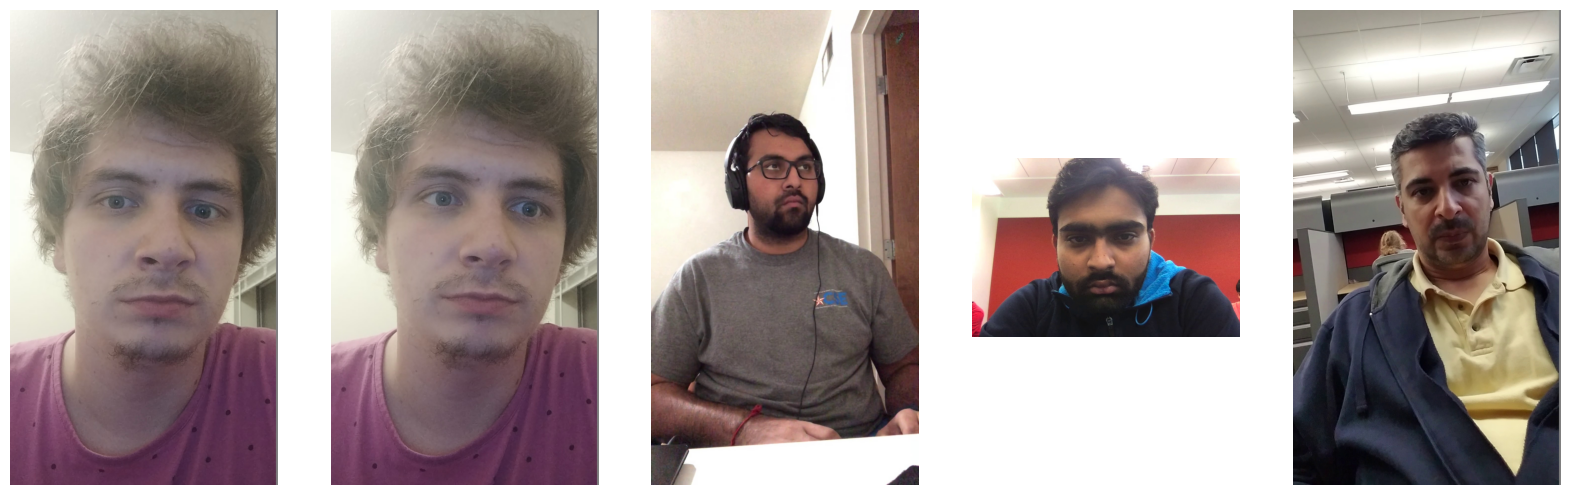

In [8]:
active_images = read_images("../data/original/Active Subjects",limit=300)
display_images(active_images[:5])

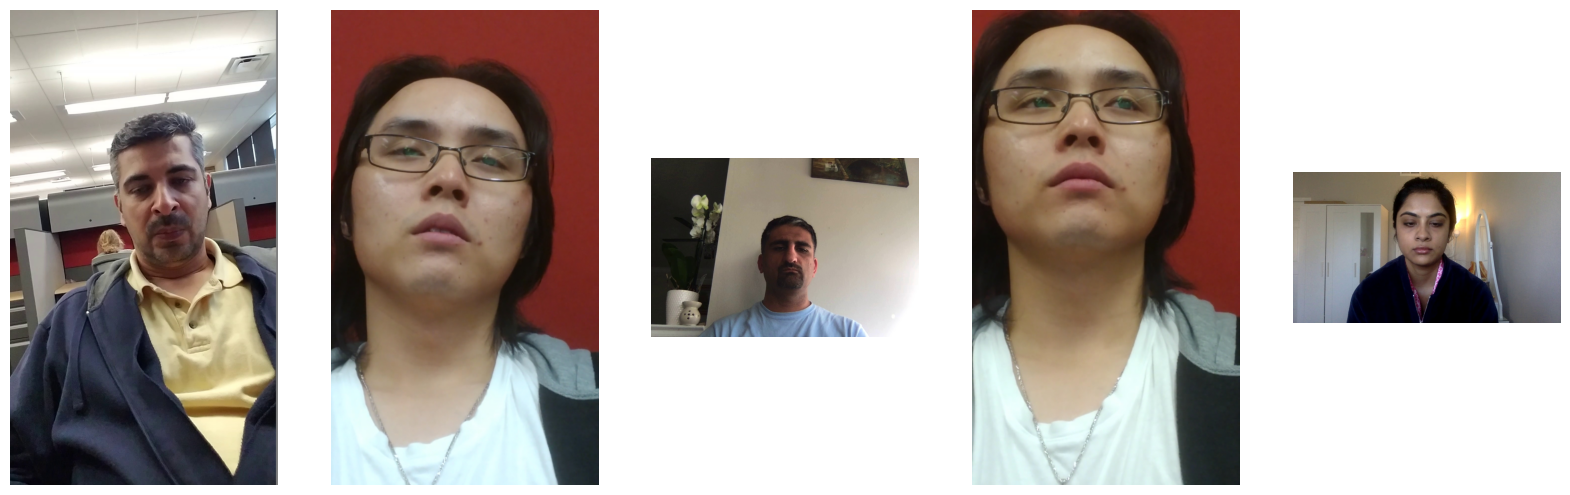

In [9]:
fatigue_images = read_images("../data/original/Fatigue Subjects",limit=300)
display_images(fatigue_images[:5])

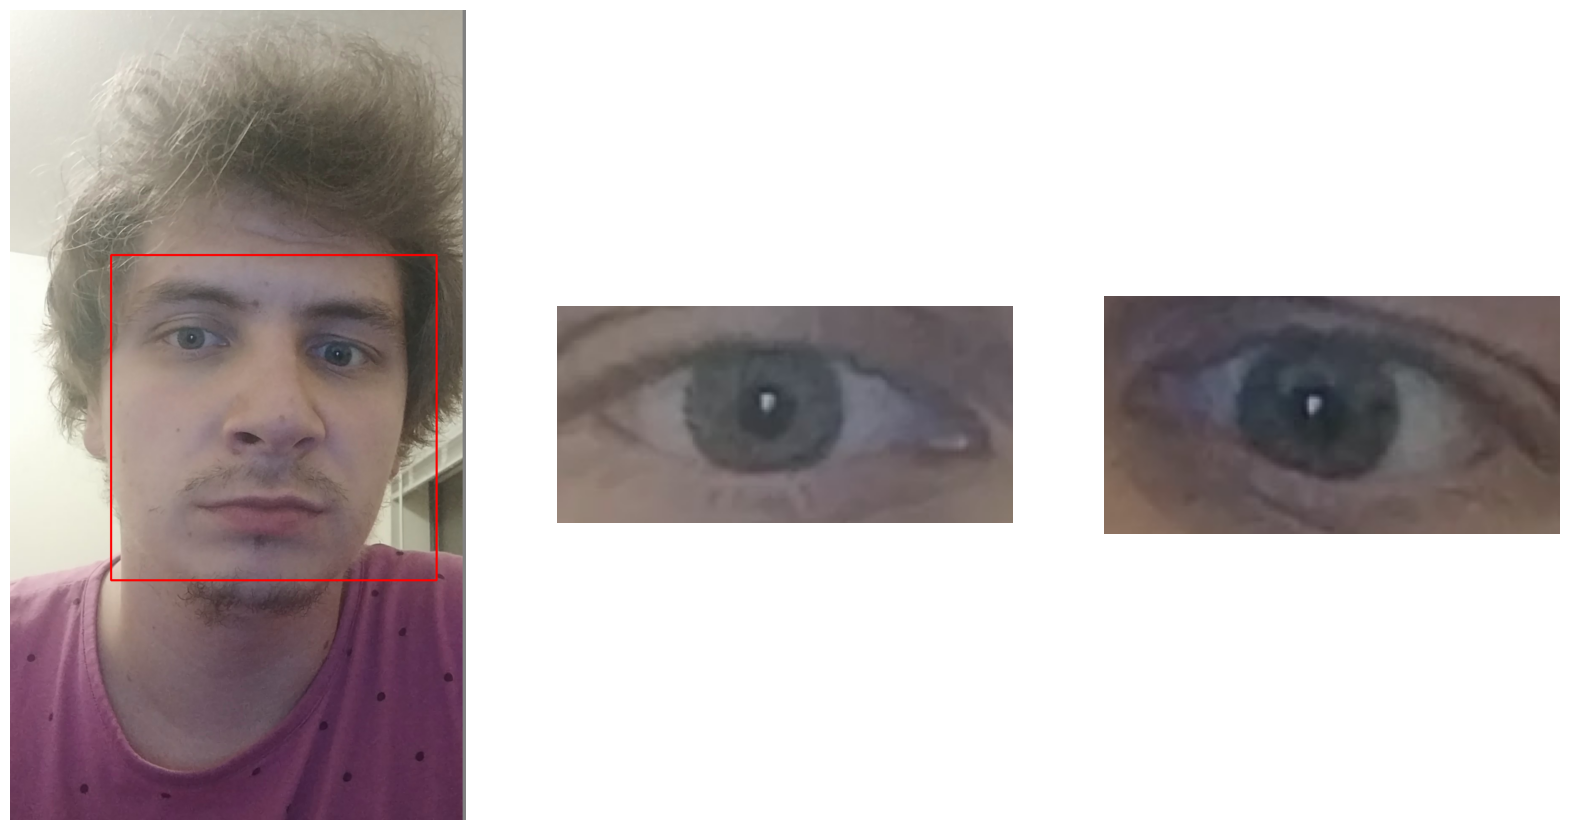

In [10]:
active_eyes=Eye.extractor_img(active_images[0])
x=(active_images[0],active_eyes[0],active_eyes[1])
display_images(x)

In [11]:
# Extract the eyes from the images and save them in the data folder
active_eyes = []
fatigue_eyes = []
for i in range(300):
	active_eyes.extend(Eye.extractor_img(active_images[i]))
	fatigue_eyes.extend(Eye.extractor_img(fatigue_images[i]))

Active Eyes:
594
Fatigue Eyes:
568
Active Eyes:


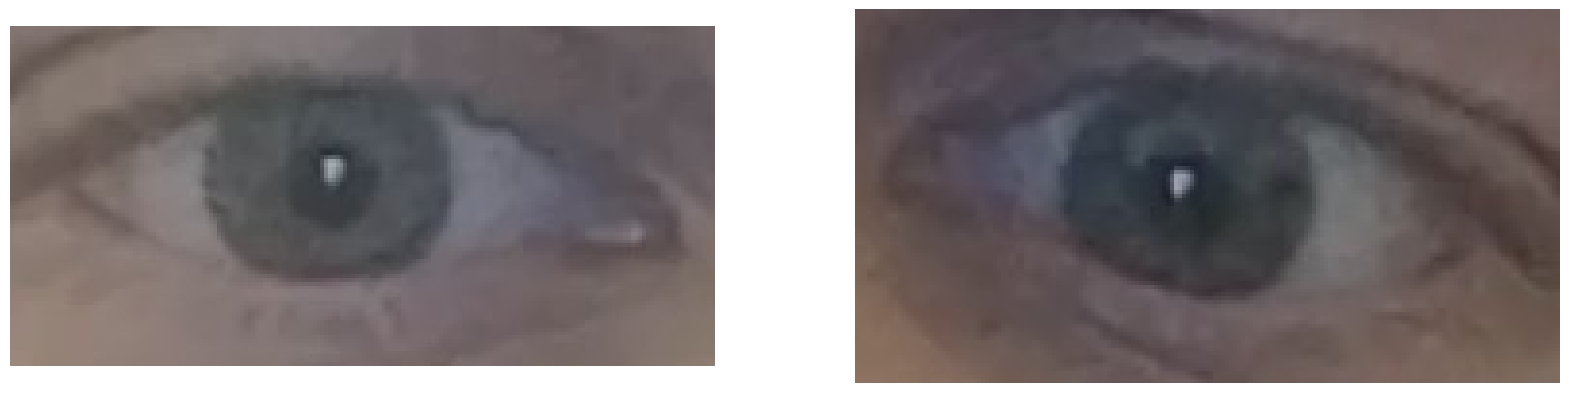

Fatigue Eyes:


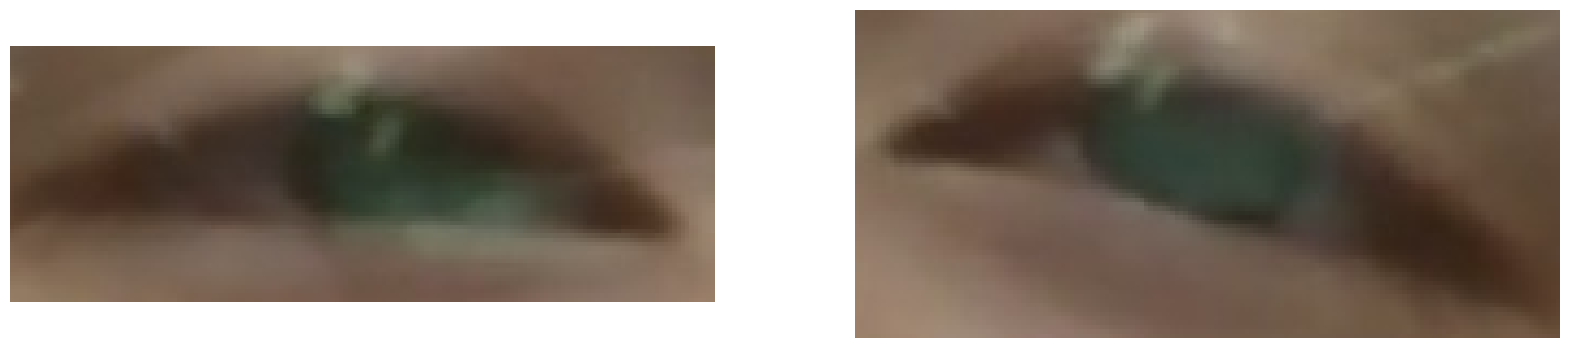

In [12]:
# find no. of eyes extracted from the images
print("Active Eyes:", len(active_eyes), "Fatigue Eyes:", len(fatigue_eyes), sep="\n")
print("Active Eyes:")
display_images([active_eyes[0], active_eyes[1]])
print("Fatigue Eyes:")
display_images([fatigue_eyes[0], fatigue_eyes[1]])

In [13]:
save_images(active_images, "../data/subsets/Active")
save_images(fatigue_images, "../data/subsets/Fatigue")
save_eyes(active_eyes, "../data/samples/Active_Eyes")
save_eyes(fatigue_eyes, "../data/samples/Fatigue_Eyes")